## Packages

In [1418]:
import sklearn
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Part I

#### Import csv files

In [1419]:
# Import the data
tree = pd.read_csv('tree.csv')
tree['t'] = tree['t'].replace(to_replace=0, value=0.0001)

vert_genes = pd.read_csv('vert_genes.csv')

In [1420]:
# Creating the graph

def create_graph(tree, alpha = 0.4, beta = 1, sigma_sq = 2500):
    G = nx.DiGraph()
    for _, row in tree.iterrows():
        if not pd.isna(row['Parent']):
            G.add_edge(int(row["Parent"]), int(row["Child"]), time = row["t"], a = alpha*row["t"], b = beta, variance = sigma_sq*row["t"])
            
    return G

G = create_graph(tree)

#### Plots

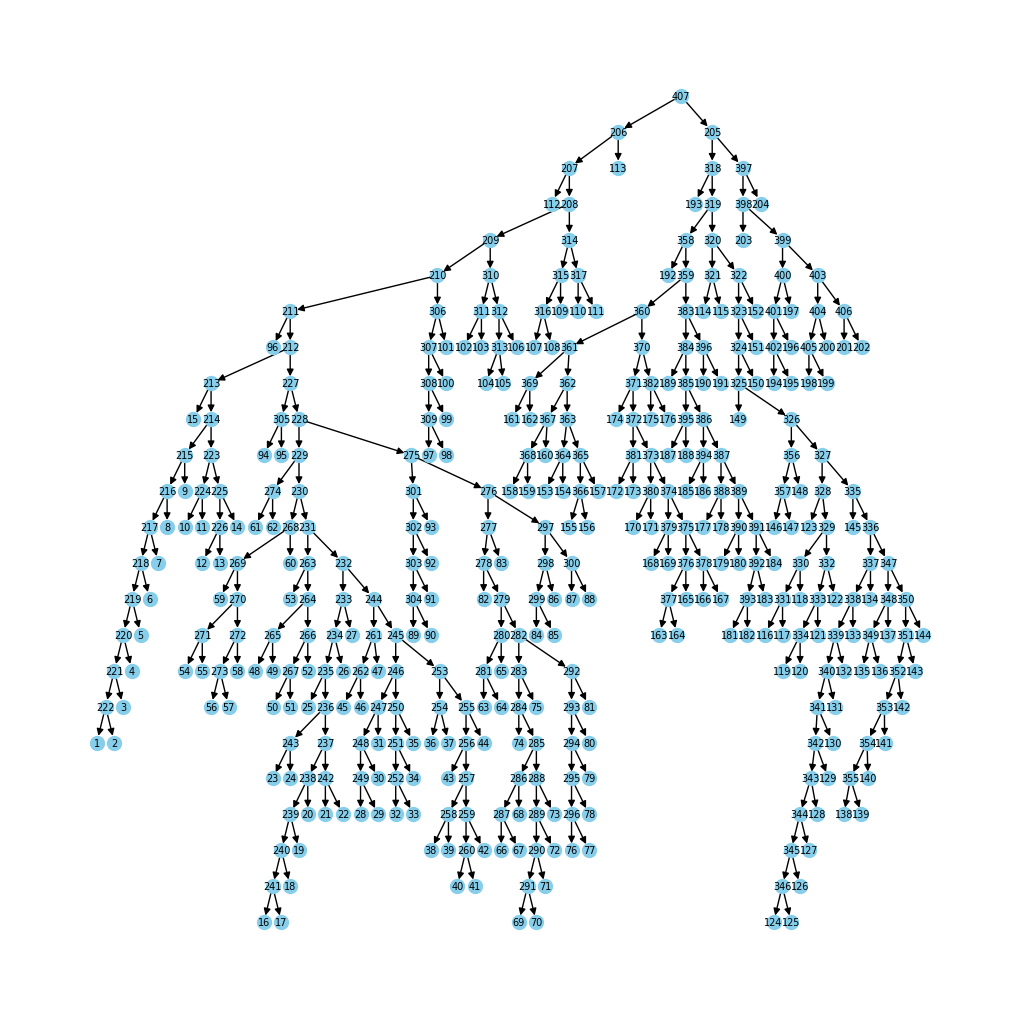

In [1421]:
# Plot the graph as a top-down tree
plt.figure(figsize=(10, 10))
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, font_size = 7, node_color = "Skyblue", node_size = 100)
plt.show()

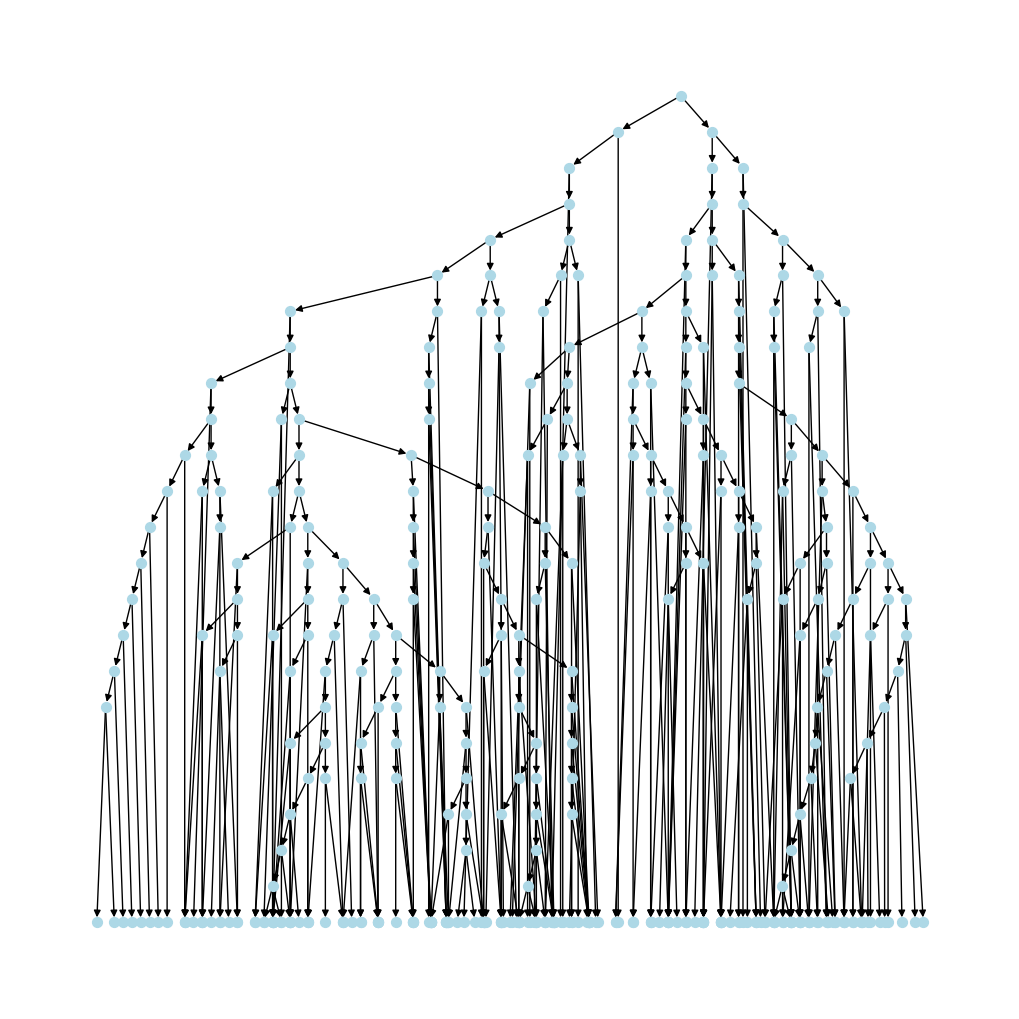

In [1422]:
# Get initial layout
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")

nodes = list(G.nodes)

# Find leaf nodes (nodes with no outgoing edges)
leaves = [node for node in nodes if G.out_degree(node) == 0]

# Find minimum depth of the tree
min_depth = min(pos[node][1] for node in pos)  # Highest Y value

# Adjust leaf positions to be at min_depth
for leaf in leaves:
    pos[leaf] = (pos[leaf][0], min_depth)

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_size=50, node_color="lightblue", edge_color="black")
plt.show()

#### Simulations

In [1423]:
# Parameters
alpha_0 = 50000
alpha = 0.5
sigma_0_sq = 5000
sigma_sq = 2500
beta = 1

# Simulate length of root node
root = 407

# Function to simulate the length of a node
def simulate_node_length(parent, simulated_lengths):
    for child in G.successors(parent):
        t = G[parent][child]['time']
        mean = alpha * t + beta * simulated_lengths[parent]
        std = np.sqrt(sigma_sq * t)
        simulated_lengths[child] = np.random.normal(mean, std)
        simulate_node_length(child, simulated_lengths)
    
    return simulated_lengths

In [1424]:
n = 1000

def simulate_data(n):
    

    X_values = []
    Y_values = []

    leaf_nodes = [node for node in G.nodes if G.out_degree(node) == 0]

    for i in range(n):
        simulated_lengths = {}
        simulated_lengths[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        simulated_lengths = simulate_node_length(root, simulated_lengths)

        simulated_x = [simulated_lengths[node] for node in leaf_nodes]
        X_values.append(simulated_x)
        Y_values.append(simulated_lengths[root])

    return(np.array(X_values), np.array(Y_values))

X_values, Y_values = simulate_data(n)

print(X_values.shape)
print(Y_values.shape)

(1000, 204)
(1000,)


In [1425]:
print(Y_values[0])

49984.60425443626


#### Linear regression model

In [1426]:
model = LinearRegression()

X_train, X_test, Y_train, Y_test = train_test_split(X_values, Y_values, test_size = 0.2)
model.fit(X_train, Y_train)

slope = model.coef_
intercept = model.intercept_

# print(slope)
# print(intercept)

Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2: {r2}")


Mean Absolute Error: 58.76134309222409
Mean Squared Error: 5505.9366358942325
Root Mean Squared Error: 74.20199886724234
R^2: -0.021656373355771308


#### Linear regression plots

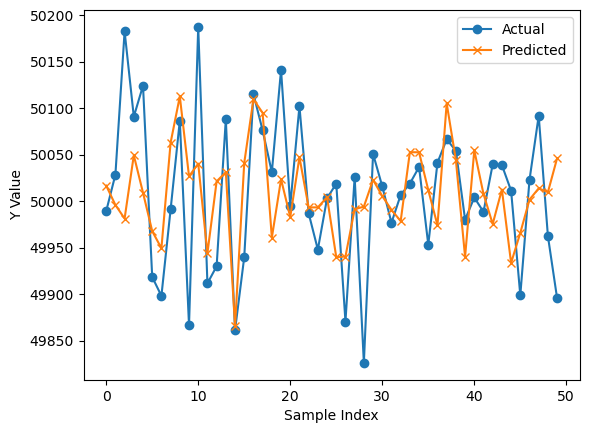

In [1427]:
points = 50

plt.plot(Y_test[:points], label="Actual", marker='o')  # First 100 values
plt.plot(Y_pred[:points], label="Predicted", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Y Value")
plt.legend()
plt.show()

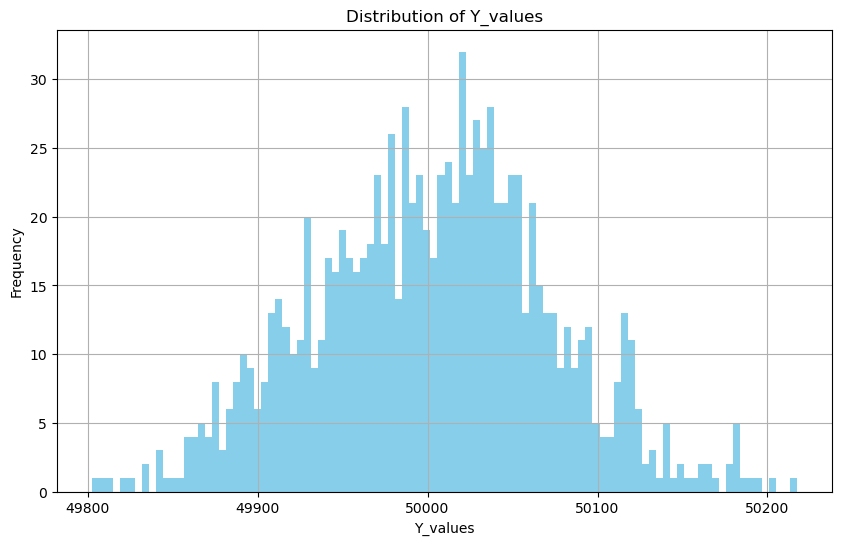

In [1428]:
plt.figure(figsize=(10, 6))
plt.hist(Y_values, bins=100, color='skyblue')
plt.title('Distribution of Y_values')
plt.xlabel('Y_values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


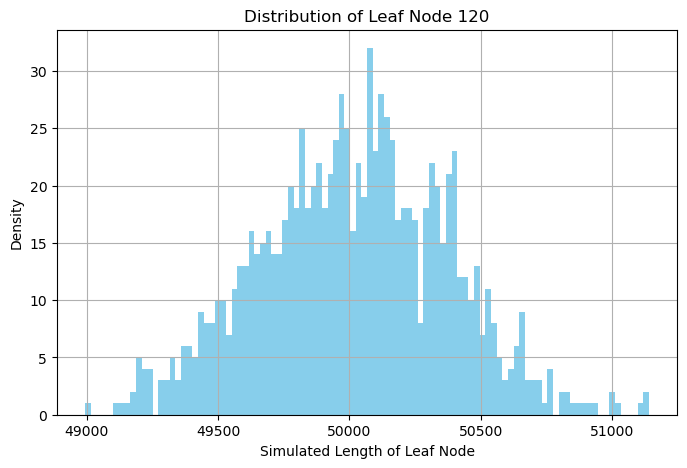

In [1429]:
leaf_index = np.random.randint(0,203)  # Choose the index of the leaf node you want to analyze
leaf_data = X_values[:, leaf_index]  # Extract the column for this leaf

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(leaf_data, bins=100, color='skyblue')

# Add labels
plt.xlabel("Simulated Length of Leaf Node")
plt.ylabel("Density")
plt.grid(True)
plt.title(f"Distribution of Leaf Node {leaf_index}")

plt.show()

# Part II

#### Clique tree

In [1430]:
all_parents = tree["Parent"].unique()

# Find the leaf nodes (parents that do not appear in the 'Child' column)
leaf_nodes = [parent for parent in all_parents if parent not in tree["Child"].values]

In [1431]:
def get_first_n_nodes(G, root, n):
    nodes = [root]
    current_level = [root]
    while len(nodes) < n:
        next_level = []
        for node in current_level:
            children = list(G.successors(node))
            next_level.extend(children)
            nodes.extend(children)
            if len(nodes) >= n:
                subgraph = G.subgraph(nodes[:n])
                mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
                return nx.relabel_nodes(subgraph, mapping)
        current_level = next_level
    subgraph = G.subgraph(nodes[:n])
    mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
    return nx.relabel_nodes(subgraph, mapping)

#### Gamma, beta, sigma, J and h

In [1432]:
def compute_gamma(G):
    # Initialize gamma as an identity matrix
    gamma = np.eye(len(G.nodes))

    # Iterate through the nodes
    for node in G.nodes:
        # Get the parent of the node (if exists)
        parent = next(G.predecessors(node), None)
        if parent is None:
            print(f"Node {node} is the root node")
            continue
        
        # Access the edge attribute 'b' for the edge from 'parent' to 'node'
        b = G[parent][node]['b']  # Access the edge (parent -> node) to get 'b'

        gamma[parent-1, node-1] = -b

    return gamma

def compute_beta(G):
    beta = np.zeros((len(G.nodes), 1))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            continue
        a = G[parent][node]['a']
        beta[node-1] = G[parent][node]['a']
        
    return beta

def compute_sigma(G):
    sigma = np.zeros((len(G.nodes)))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            # Assign the default value for the root node
            sigma[node - 1] = sigma_0_sq
        else:
            # Access the edge attribute 'variance' only if parent exists
            variance = G[parent][node]['variance']
            sigma[node - 1] = variance
    return sigma

beta = compute_beta(G)
sigma = compute_sigma(G)
gamma = compute_gamma(G)

def compute_J(gamma, sigma):
    J = np.zeros_like(gamma)
    
    # Iterate over each row in gamma
    for i in range(len(gamma)):
        # Get the i-th row (gamma_i) and the corresponding sigma_i
        gamma_i = gamma[i, :]
        sigma_i = sigma[i]
        
        # Compute the outer product of gamma_i with itself, scaled by 1/sigma_i^2 
        outer_product = np.outer(gamma_i, gamma_i) / (sigma_i) # MAYBE USE SIGMA_I^2
        
        # Add the outer product to the sum matrix
        J += outer_product
    
    return J

J = compute_J(gamma, sigma)
h = np.sum([(beta[i] / sigma[i]) * gamma[i] for i in range(len(G))], axis=0)

computed_covariance = np.linalg.inv(J)

negative_indices = np.where(J < 0)
negative_values = J[negative_indices]

print(f"Number of negative values in J: {negative_values.size}")

if negative_values.size > 0:
    print("Negative values in J:")
    for index, value in zip(zip(*negative_indices), negative_values):
        print(f"Index: {index}, Value: {value}")
else:
    print("All values in J are non-negative.")

Node 407 is the root node
Number of negative values in J: 812
Negative values in J:
Index: (0, 221), Value: -0.00012608526799548551
Index: (1, 221), Value: -0.00012608526799548551
Index: (2, 220), Value: -0.00015926338274126575
Index: (3, 219), Value: -0.00016816528296733865
Index: (4, 218), Value: -0.00017905798486704885
Index: (5, 217), Value: -0.00018952612809550938
Index: (6, 216), Value: -0.00020186279565266943
Index: (7, 215), Value: -0.00017493652446087593
Index: (8, 214), Value: -0.00017910753431676934
Index: (9, 223), Value: -0.00012307692307692307
Index: (10, 223), Value: -0.00012307692307692307
Index: (11, 225), Value: -0.0005333333333333334
Index: (12, 225), Value: -0.0005333333333333334
Index: (13, 224), Value: -0.0002
Index: (14, 212), Value: -0.00017324442667204974
Index: (15, 240), Value: -0.0008
Index: (16, 240), Value: -0.0008
Index: (17, 239), Value: -0.0004
Index: (18, 238), Value: -7.804878048780487e-05
Index: (19, 237), Value: -0.001163619438262711
Index: (20, 241

#### Simulations for comparison

In [1433]:
# Number of simulations
n = 1000

def simulate_node_length(node, simulated_lengths):
    for child in G.successors(node):
        # parent_length = simulated_lengths[node]  # Get the parent's simulated value
        # t = G[node][child]['time']  # Time from parent to child
        # mean = alpha * t + beta * simulated_lengths[node] # Mean value for the child node
        a = G[node][child]['a']
        variance = G[node][child]['variance']
        
        # Simulate child node value
        simulated_lengths[child] = np.random.normal(a * simulated_lengths[node], np.sqrt(variance))
        
        # Recursively simulate for its children
        simulate_node_length(child, simulated_lengths)
    
    return simulated_lengths

def simulate_data(n):
    X_values = []
    Y_values = []
    
    all_nodes = list(G.nodes)  # Get all nodes in the graph

    for _ in range(n):
        simulated_lengths = {}
        
        # Simulate root node first
        simulated_lengths[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        
        # Simulate all other nodes recursively
        simulated_lengths = simulate_node_length(root, simulated_lengths)
        
        # Store all node values in order
        X_values.append([simulated_lengths[node] for node in all_nodes])
        Y_values.append(simulated_lengths[root])  # Root node as target
    
    return np.array(X_values), np.array(Y_values)

# Run simulation
X_values, Y_values = simulate_data(n)

# Print shapes to verify
print(X_values.shape)  # Should be (1000, total number of nodes)
print(Y_values.shape)  # Should be (1000,)


(1000, 407)
(1000,)


In [1434]:
covariance = np.cov(X_values, rowvar=False)
J_estimate = np.linalg.inv(covariance)

print(covariance)

covariance

[[ 61949.3984594  222938.27048804 221860.00439997 ...    843.51160547
   12540.88407338   8528.13246091]
 [222938.27048804 823919.63774829 798297.12734936 ...   4197.78505145
   49515.91703815  33373.55425983]
 [221860.00439997 798297.12734936 818455.37377141 ...   1621.93837339
   49242.35157665  32954.38218807]
 ...
 [   843.51160547   4197.78505145   1621.93837339 ...  13667.80949016
   28862.24544147  18870.96253456]
 [ 12540.88407338  49515.91703815  49242.35157665 ...  28862.24544147
  400833.83194816 261536.52076051]
 [  8528.13246091  33373.55425983  32954.38218807 ...  18870.96253456
  261536.52076051 174670.19620052]]


array([[ 61949.3984594 , 222938.27048804, 221860.00439997, ...,
           843.51160547,  12540.88407338,   8528.13246091],
       [222938.27048804, 823919.63774829, 798297.12734936, ...,
          4197.78505145,  49515.91703815,  33373.55425983],
       [221860.00439997, 798297.12734936, 818455.37377141, ...,
          1621.93837339,  49242.35157665,  32954.38218807],
       ...,
       [   843.51160547,   4197.78505145,   1621.93837339, ...,
         13667.80949016,  28862.24544147,  18870.96253456],
       [ 12540.88407338,  49515.91703815,  49242.35157665, ...,
         28862.24544147, 400833.83194816, 261536.52076051],
       [  8528.13246091,  33373.55425983,  32954.38218807, ...,
         18870.96253456, 261536.52076051, 174670.19620052]])

#### Conditional distributions

In [1435]:
# Compute the conditional distribution of Z_0,...Z_n given X_0,...X_n

def compute_conditional_distribution(observed_X, J, h, n_observed):
    # observed_X: vector of length n_observed (values of observed vars)
    # n_observed: number of observed variables

    # X are first n_observed vars, Z are the rest
    J_xx = J[:n_observed, :n_observed]
    J_xz = J[:n_observed, n_observed:]
    J_zx = J[n_observed:, :n_observed]
    J_zz = J[n_observed:, n_observed:]

    h_x = h[:n_observed]
    h_z = h[n_observed:]

    y = observed_X  # shape (n_observed,)
    
    # Print debug statements about shapes
    # print(f"Shape of J_xx: {J_xx.shape}")
    # print(f"Shape of J_xz: {J_xz.shape}")
    # print(f"Shape of J_zx: {J_zx.shape}")
    # print(f"Shape of J_zz: {J_zz.shape}")
    # print(f"Shape of h_x: {h_x.shape}")
    # print(f"Shape of h_z: {h_z.shape}")
    # print(f"Shape of observed_X (y): {y.shape}")

    # new h is conditioned on X
    new_h = h_z - J_zx @ y

    return J_zz, new_h



def simX(n):
    
    X_values = []

    leaf_nodes = [node for node in G.nodes if G.out_degree(node) == 0]

    for i in range(n):
        simulated_lengths = {}
        simulated_lengths[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        simulated_lengths = simulate_node_length(root, simulated_lengths)

        simulated_x = [simulated_lengths[node] for node in leaf_nodes]
        X_values.append(simulated_x)

    return(np.array(X_values))

X_values = simX(1000)

print(X_values.shape)

X = X_values[0]

print("X.shape", X.shape)

conditional_J, conditional_h = compute_conditional_distribution(X,J,h, 204)


print(conditional_J.shape)
print(J.shape)

(1000, 204)
X.shape (204,)
(203, 203)
(407, 407)


In [1436]:
def compute_clique_tree(G):
    C = nx.Graph()

    G_working = G.copy()
    leaves = [node for node in G_working.nodes if G_working.out_degree(node) == 0]
    G_working.remove_nodes_from(leaves)

    index = min(G_working.nodes) -1 if all(isinstance(n, int) for n in G_working.nodes) else 0
    print("Starting index is ", index)

    for node in G_working.nodes:
        parent = node
        children = list(G_working.neighbors(parent))
        C.add_node(parent, variables=[parent])
        for child in children:
            pair_clique = index
            C.add_node(pair_clique, variables=[parent, child])
            C.add_edge(parent, pair_clique)
            C.add_edge(pair_clique, child)
            index = index - 1

    return C


C = compute_clique_tree(G)

print("Number of nodes in G:", G.number_of_nodes())
print("Number of edges in G:", G.number_of_edges())

print("Number of nodes in C:", C.number_of_nodes())
print("Number of edges in C:", C.number_of_edges())


print(C.nodes[407]['variables'])  # Output: [407]
# Output: {'variables': [220]}

Starting index is  204
Number of nodes in G: 407
Number of edges in G: 406
Number of nodes in C: 405
Number of edges in C: 404
[407]


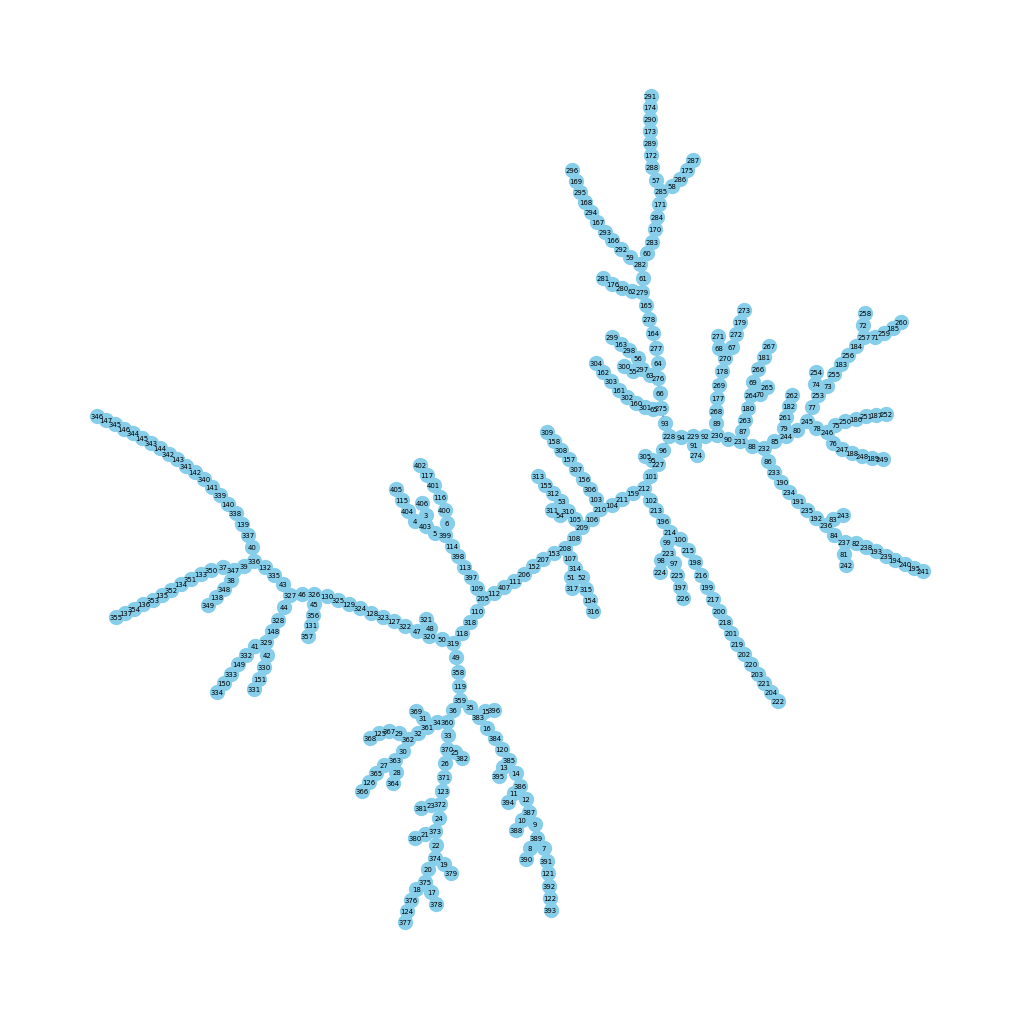

True

In [1437]:
plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(C)  # Use Graphviz 'dot' layout
nx.draw(C, pos, with_labels=True, font_size=5, node_color="Skyblue", node_size=100, arrows=False)
plt.show()

def is_acyclic_tree(G):
    # Check if the graph is connected
    is_connected = nx.is_connected(G)
    
    # Check if the graph is acyclic by ensuring no cycles exist
    is_acyclic = nx.is_tree(G)  # nx.is_tree directly checks if the graph is acyclic and connected
    
    return is_connected and is_acyclic

is_acyclic_tree(C)

#### Clique Tree

In [1438]:
# ### Removes leaves from the original tree
# def remove_leaves(G):
#     # Create a copy of the graph to modify it while iterating
#     H = G.copy()
    
#     # Find all nodes with out-degree of 0 which are leaves
#     leaves = [node for node in G.nodes() if G.out_degree(node) == 0]
    
#     # Remove the identified leaf nodes
#     H.remove_nodes_from(leaves)
    
#     return H

# G_no_leaves = remove_leaves(G)

# # Creates junction tree
# clique_tree = nx.junction_tree(G_no_leaves)

# print((len(nx.nodes(clique_tree))))

# # Adding new leaf nodes based on the second item of their parent's node tuple
# leaf_nodes = [node for node in clique_tree.nodes() if clique_tree.degree(node) == 1]  # Identify leaf nodes
# for leaf in leaf_nodes:
#     if isinstance(leaf, tuple) and len(leaf) > 1:  # Check if the node is a tuple and has at least two elements
#         new_leaf = (leaf[1],)  # Name the new leaf after the second item of the tuple
#         clique_tree.add_node(new_leaf)
#         clique_tree.add_edge(leaf, new_leaf)
        
# ### Completed junction tree nodes have output as a tuple. ex. (346,) if singleton node, (346, 347) if not singleton node
    
# print(len(nx.nodes(clique_tree)))

# clique_tree.nodes()
# print(clique_tree.has_node((346,)))

# # Define a layout for better spacing
# pos = nx.kamada_kawai_layout(clique_tree)

# # Draw the updated clique tree
# plt.figure(figsize=(20, 20))
# nx.draw(
#     clique_tree, pos,
#     with_labels=True,
#     node_color="skyblue",
#     node_size=100,
#     edge_color="gray",
#     width=1.5,
#     font_size=6,
#     font_color="black"
# )
# plt.show()

#### Message passing algorithm

In [1439]:
NoV = len([node for node in C.nodes if len(C.nodes[node]['variables']) == 1]) -1
maxIndex = max([node for node in C.nodes])
away_from_zero = maxIndex - NoV
minIndex = min([node for node in C.nodes if len(C.nodes[node]['variables']) == 1])

print("Away from zero: ", away_from_zero)
print("Max index: ", maxIndex)
print("Min index: ", minIndex)
print("Number of variables in the graph: ", NoV)

def mapping_GTM(index_in_graph):
    return index_in_graph - away_from_zero 

def mapping_MTG(index_in_graph):
    return index_in_graph + away_from_zero

# def compute_message_STP(i, j, index_j, J, clique_tree, J_messages, h_messages):
    
#     neighbors = list(clique_tree.neighbors(i))
#     neighbors.remove(j)

#     index_j = mapping_GTM(index_j)
#     i = mapping_GTM(i)

#     J_ji = J[index_j][i]
#     J_ij = J[i][index_j]

#     prev_J_message = J_messages[i][index_j]
#     prev_h_message = h_messages[i]

#     J_message = -np.dot(J_ji, J_ij) / prev_J_message
#     h_message = -np.dot(J_ji, prev_h_message) / prev_J_message

#     J_messages[i][index_j] = J_message
#     h_messages[i] = h_message

# def compute_message_PTS(i, index_i, j, J, h, clique_tree, J_messages, h_messages):
    
#     neighbors = list(clique_tree.neighbors(i))
#     neighbors.remove(j)

#     index_i = mapping_GTM(index_i)
#     j = mapping_GTM(j)
    
#     if neighbors is not None:
#         J_sum = np.sum([J_messages[mapping_GTM(k)][index_i] for k in neighbors])
#         h_sum = np.sum([h_messages[mapping_GTM(k)] for k in neighbors])

#     J_hat_ij = J[index_i][index_i] + J_sum
#     h_hat_ij = h[index_i] + h_sum

#     J_messages[index_i][j] = J_hat_ij
#     h_messages[index_i] = h_hat_ij

# def upward_pass(clique_tree, J, h, root):

#     flags = np.zeros(root + 1)
#     order = nx.dfs_postorder_nodes(clique_tree, source=root)

#     # order = list(order)[:10]
#     J_messages = np.zeros(shape=(J.shape[0] + 2, J.shape[1] + 2))
#     h_messages = np.zeros(shape=(h.shape[0] + 2,))

#     for n in order:
#         neighbors = list(clique_tree.neighbors(n))
#         for j in neighbors:
#             if flags[j] == 0:
#                 variables = clique_tree.nodes[n]['variables']
#                 if len(variables) == 2:
#                     i = n
#                     index_i = variables[0]
#                     j = variables[0]
#                     compute_message_PTS(i, index_i, j, J, h, clique_tree, J_messages, h_messages)
#                 else:
#                     neighbor_variables = clique_tree.nodes[j]['variables']
#                     index_j = neighbor_variables[0]
#                     i = n
#                     compute_message_STP(i, j, index_j, J, clique_tree, J_messages, h_messages)
#                 flags[j] = 1
#             else:
#                 continue

#     return J_messages, h_messages

# def downward_pass(clique_tree, J, h, root, J_messages, h_messages):
    
#     order = nx.dfs_preorder_nodes(clique_tree, source=root)
#     flags = np.zeros(root + 1)

#     for n in order:
#         neighbors = list(clique_tree.neighbors(n))
#         for j in neighbors:
#             if flags[j] == 0:
#                 variables = clique_tree.nodes[n]['variables']
#                 print("Variables for clique", n, ": ", variables)
#                 if len(variables) == 2:
#                     i = n
#                     index_i = variables[0]
#                     j = variables[1]
#                     compute_message_PTS(i, index_i, j, J, h, clique_tree, J_messages, h_messages)
#                 else:
#                     neighbor_variables = clique_tree.nodes[j]['variables']
#                     index_j = neighbor_variables[0]
#                     i = n
#                     compute_message_STP(i, j, index_j, J, clique_tree, J_messages, h_messages)
#                 flags[j] = 1
#             else:
#                 continue

#     return J_messages, h_messages

# def compute_clique_beliefs(clique_tree, J, h, J_messages, h_messages):
    
#     clique_j = np.zeros(shape=h.shape)
#     clique_h = np.zeros(shape=h.shape)
    
#     number_of_variables = len(h)
#     for i in range(number_of_variables):
#         J_i = J[i][i]
#         h_i = h[i]

#         graph_i = mapping_MTG(i)

#         for neighbor in clique_tree.neighbors(graph_i):
#             J_message = J_messages[neighbor][i]
#             h_message = h_messages[neighbor]
#             J_i += J_message
#             h_i += h_message
        
#         clique_j[i] = J_i
#         clique_h[i] = h_i

#     return clique_j, clique_h

# def message_passing(J, h, clique_tree, root):
    
#     J_messages_up, h_messages_up = upward_pass(clique_tree, J, h, root)
#     J_messages_down, h_messages_down = downward_pass(clique_tree, J, h, root, J_messages_up, h_messages_up)
#     clique_j, clique_h = compute_clique_beliefs(clique_tree, J, h, J_messages_down, h_messages_down)

#     return J_messages_down, h_messages_down

# root = C.nodes[407]['variables'][0]

# J_messages_down, h_messages_down = message_passing(conditional_J, conditional_h, C, root=407)


Away from zero:  205
Max index:  407
Min index:  205
Number of variables in the graph:  202


In [1440]:
def compute_J_i_arrow_j(clique_tree, i, j, J, h, J_messages, h_messages):
    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)

    i = mapping_GTM(i)
    j = mapping_GTM(j)

    if len(neighbors) == 0:
        J_messages[i,j] = -J[i,j]*J[j,i] / J[i,i]
        return J_messages[i,j]
    else:
        J_ii = J[i,i]
        J_sum = np.sum([compute_J_i_arrow_j(clique_tree, k, mapping_MTG(i), J, h, J_messages, h_messages) for k in neighbors])
        J_messages[i,j] = -J[i,j]*J[j,i] / (J_ii + J_sum)
        return J_messages[i,j]

def compute_h_i_arrow_j(clique_tree, i, j, J, h, J_messages, h_messages):
    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)

    i = mapping_GTM(i)
    j = mapping_GTM(j)

    if len(neighbors) == 0:
        h_messages[i,j] = -J[i,j]*h[i] / J[i,i]
        return h_messages[i,j]
    else:
        J_ii = J[i,i]
        h_i = h[i]
        J_sum = np.sum([compute_J_i_arrow_j(clique_tree, k, mapping_MTG(i), J, h, J_messages, h_messages) for k in neighbors])
        h_sum = np.sum([compute_h_i_arrow_j(clique_tree, k, mapping_MTG(i), J, h, J_messages, h_messages) for k in neighbors])
        h_messages[i,j] = (-J[i,j]*h_i - J[i,j]*h_sum) / (J_ii + J_sum)
        return h_messages[i,j]

def inference_algorithm(clique_tree, J, h, observed_X, Z):

    clique_tree = clique_tree.copy()
    leaves = [node for node in clique_tree.nodes if clique_tree.out_degree(node) == 0]
    clique_tree.remove_nodes_from(leaves)

    clique_tree = clique_tree.to_undirected()
    J_messages = np.full(J.shape, np.nan)
    h_messages = np.full(J.shape, np.nan)
    n_observed = len(observed_X)
    J_reduced, h_reduced = compute_conditional_distribution(observed_X, J, h, n_observed)

    Z_neighbors = list(clique_tree.neighbors(Z))
    Z_index = mapping_GTM(Z)
    print("Z index is ", Z_index)

    J_zz = J_reduced[Z_index,Z_index]
    print("J_zz is ", J_zz)
    sum_part = np.sum([compute_J_i_arrow_j(clique_tree, k, Z, J_reduced, h_reduced, J_messages, h_messages) for k in Z_neighbors])
    print("Sum part is ", sum_part)
    print("J_hat_Z is ", J_zz + sum_part)
    J_hat_Z = J_reduced[mapping_GTM(Z),mapping_GTM(Z)] + np.sum([compute_J_i_arrow_j(clique_tree, k, Z, J_reduced, h_reduced, J_messages, h_messages) for k in Z_neighbors])
    h_hat_Z = h_reduced[mapping_GTM(Z)] + np.sum([compute_h_i_arrow_j(clique_tree, k, Z, J_reduced, h_reduced, J_messages, h_messages) for k in Z_neighbors])

    return J_hat_Z, h_hat_Z


random_index = np.random.choice(range(1000))
J_hat_Z, h_hat_Z = inference_algorithm(G, J, h, X_values[random_index], 407)
    
def information_to_standard(J_hat_Z, h_hat_Z):
    mu = h_hat_Z / J_hat_Z
    sigma = np.sqrt(1 / J_hat_Z)
    return mu, sigma

mu, sigma = information_to_standard(J_hat_Z, h_hat_Z)

mu, sigma

Z index is  202
J_zz is  0.0002
Sum part is  -0.0012682223933619266
J_hat_Z is  -0.0010682223933619265


C:\Users\Dell\AppData\Local\Temp\ipykernel_9500\3588248648.py:67: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(1 / J_hat_Z)


(-402263.86619396496, nan)

In [1441]:
mu_preds = []
for i in range(n):
    J_hat_Z, h_hat_Z = inference_algorithm(G, J, h, X_values[i], 407)
    print(f"J_hat_Z: {J_hat_Z}")
    print(f"h_hat_Z: {h_hat_Z}")
    mu, sigma = information_to_standard(J_hat_Z, h_hat_Z)
    mu_preds.append(mu)

for i in range(5):
    print(f"True: {Y_values[i]}, Pred: {mu_preds[i]}")


mu_preds = np.array(mu_preds)

print("MSE between predicted and true root values:", np.mean((mu_preds - Y_values)**2))
print("Correlation:", np.corrcoef(mu_preds, Y_values)[0, 1])


Z index is  202
J_zz is  0.0002
Sum part is  -0.0012682223933619266
J_hat_Z is  -0.0010682223933619265
J_hat_Z: -0.0010682223933619265
h_hat_Z: 434.58060202577263
Z index is  202
J_zz is  0.0002
Sum part is  -0.0012682223933619266
J_hat_Z is  -0.0010682223933619265
J_hat_Z: -0.0010682223933619265
h_hat_Z: 435.41325327960965
Z index is  202
J_zz is  0.0002
Sum part is  -0.0012682223933619266
J_hat_Z is  -0.0010682223933619265
J_hat_Z: -0.0010682223933619265
h_hat_Z: 434.65341859232865


C:\Users\Dell\AppData\Local\Temp\ipykernel_9500\3588248648.py:67: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(1 / J_hat_Z)


Z index is  202
J_zz is  0.0002
Sum part is  -0.0012682223933619266
J_hat_Z is  -0.0010682223933619265
J_hat_Z: -0.0010682223933619265
h_hat_Z: 434.3888058721456
Z index is  202
J_zz is  0.0002
Sum part is  -0.0012682223933619266
J_hat_Z is  -0.0010682223933619265
J_hat_Z: -0.0010682223933619265
h_hat_Z: 436.3978050432249
Z index is  202
J_zz is  0.0002
Sum part is  -0.0012682223933619266
J_hat_Z is  -0.0010682223933619265
J_hat_Z: -0.0010682223933619265
h_hat_Z: 435.9641818871
Z index is  202
J_zz is  0.0002
Sum part is  -0.0012682223933619266
J_hat_Z is  -0.0010682223933619265
J_hat_Z: -0.0010682223933619265
h_hat_Z: 432.9377828611537
Z index is  202
J_zz is  0.0002
Sum part is  -0.0012682223933619266
J_hat_Z is  -0.0010682223933619265
J_hat_Z: -0.0010682223933619265
h_hat_Z: 432.67996989626414
Z index is  202
J_zz is  0.0002
Sum part is  -0.0012682223933619266
J_hat_Z is  -0.0010682223933619265
J_hat_Z: -0.0010682223933619265
h_hat_Z: 432.1922387911162
Z index is  202
J_zz is  0.000

In [1442]:
def split_gene_data(df):

    unique_genes = df['orthId'].unique()
    length = len(unique_genes)
    print(unique_genes)
    gene_data = np.empty(length, dtype=object) 

    for i, gene in enumerate(unique_genes):
        data = df['glength'][df['orthId'] == gene].values
        print(f"Gene {gene} data: {data}")
        gene_data[i] = data

    return gene_data
        
    
result = split_gene_data(vert_genes)

result

['1CPN2' '1CQBX' '1CQJ6' '1CR8Z' '1CTEU' '1CTI9' '1CYBB' '1D0EM' '1D1CF'
 '1D3F1']
Gene 1CPN2 data: [ 66213  44913 157799  67073  95046  83890  88931   4238   4842 173713
  74387   5027  66520 102881 190050  66937   4265  72517 157660  27942
  76678  91108  69244  38257 171604 171302 203617   4242 147627   4112
  79105   4230  88182 187292   4239   5921  71367   4365  31630   4388
  89361  67824 126389   4568   4466  65704  73839 160601  68827 183361
  46699  68183 104007  48665   4250  68687   6731  31946  35820  18063
  26634  23210  12461  34159  19207  39627  39296  22154  22280  47566
  67539  27206 110726  20157  12183  30670  20712  28054  29584   3069
  20497  26695  62753   6240  44757  19611  26536  24159  29725  25090
  13570  78716 235072 249257  89073 271965 271860 269890 271513 257735
  83787  83975  78545 248947  99244 105538 227106 253796  88628 256326
 233329 258535 353701 257320  86249  89972  95274 221963 302664 370084
 108205 240821 234204  90005 129820  90485 22790

array([array([ 66213,  44913, 157799,  67073,  95046,  83890,  88931,   4238,
                4842, 173713,  74387,   5027,  66520, 102881, 190050,  66937,
                4265,  72517, 157660,  27942,  76678,  91108,  69244,  38257,
              171604, 171302, 203617,   4242, 147627,   4112,  79105,   4230,
               88182, 187292,   4239,   5921,  71367,   4365,  31630,   4388,
               89361,  67824, 126389,   4568,   4466,  65704,  73839, 160601,
               68827, 183361,  46699,  68183, 104007,  48665,   4250,  68687,
                6731,  31946,  35820,  18063,  26634,  23210,  12461,  34159,
               19207,  39627,  39296,  22154,  22280,  47566,  67539,  27206,
              110726,  20157,  12183,  30670,  20712,  28054,  29584,   3069,
               20497,  26695,  62753,   6240,  44757,  19611,  26536,  24159,
               29725,  25090,  13570,  78716, 235072, 249257,  89073, 271965,
              271860, 269890, 271513, 257735,  83787,  83975,  7

#### Elimination order

In [1443]:
def elimination_order(G):
    # Find the root (the only node with in-degree 0)
    root = [node for node in G.nodes if G.in_degree(node) == 0][0]
    
    # Compute depth (distance from root)
    depths = nx.shortest_path_length(G, source=root)
    
    # Sort nodes by depth in descending order
    ordered_nodes = sorted(depths.keys(), key=lambda node: depths[node], reverse=True)
    
    return ordered_nodes

elimination_order(G)

[124,
 125,
 16,
 17,
 69,
 70,
 126,
 346,
 18,
 241,
 40,
 41,
 71,
 291,
 127,
 345,
 19,
 240,
 38,
 39,
 42,
 260,
 66,
 67,
 72,
 290,
 76,
 77,
 128,
 344,
 138,
 139,
 20,
 239,
 21,
 22,
 28,
 29,
 32,
 33,
 258,
 259,
 68,
 287,
 73,
 289,
 78,
 296,
 129,
 343,
 140,
 355,
 238,
 242,
 23,
 24,
 30,
 249,
 34,
 252,
 43,
 257,
 286,
 288,
 79,
 295,
 130,
 342,
 141,
 354,
 1,
 2,
 237,
 243,
 31,
 248,
 35,
 251,
 36,
 37,
 44,
 256,
 74,
 285,
 80,
 294,
 131,
 341,
 142,
 353,
 3,
 222,
 25,
 236,
 247,
 250,
 254,
 255,
 45,
 46,
 50,
 51,
 56,
 57,
 63,
 64,
 75,
 284,
 81,
 293,
 119,
 120,
 132,
 340,
 135,
 136,
 143,
 352,
 4,
 221,
 26,
 235,
 246,
 253,
 47,
 262,
 48,
 49,
 52,
 267,
 54,
 55,
 58,
 273,
 65,
 281,
 283,
 292,
 116,
 117,
 121,
 334,
 133,
 339,
 137,
 349,
 144,
 351,
 163,
 164,
 181,
 182,
 5,
 220,
 27,
 234,
 245,
 261,
 265,
 266,
 271,
 272,
 280,
 282,
 84,
 85,
 89,
 90,
 118,
 331,
 122,
 333,
 134,
 338,
 348,
 350,
 165,
 377,
 166,
 